In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/gdrive/Prediction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import pandas as pd
import datetime

weather = pd.read_csv('/content/gdrive/MyDrive/Prediction/weather_in_Antwerp.csv', ';')
power_info = pd.read_csv('/content/gdrive/MyDrive/Prediction/PV_Elec_Gas3.csv')
display(weather.head())
power_info.head()

<ipython-input-4-c08ef387bb9a>:4: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  weather = pd.read_csv('/content/gdrive/MyDrive/Prediction/weather_in_Antwerp.csv', ';')


,Unnamed: 0,clock,temp,weather,wind,humidity,barometer,visibility,year,month,day
0,0,00:20,11 °C,Mostly cloudy.,17 km/h,94%,1011 mbar,5 km,2012,1,1
1,1,00:50,12 °C,Mostly cloudy.,17 km/h,88%,1011 mbar,NaN,2012,1,1
2,2,01:50,12 °C,Overcast.,19 km/h,88%,1011 mbar,9 km,2012,1,1
3,3,02:20,12 °C,Partly cloudy.,17 km/h,88%,1010 mbar,NaN,2012,1,1
4,4,02:50,12 °C,Sprinkles. Mostly cloudy.,15 km/h,88%,1010 mbar,NaN,2012,1,1


,Unnamed: 0,cum_power,Elec_kW,Gas/day
0,26/10/2011,0.1,15.1,9.0
1,27/10/2011,10.2,7.4,9.2
2,28/10/2011,20.2,5.8,8.0
3,29/10/2011,29.6,4.9,6.6
4,30/10/2011,34.2,11.7,5.3


In [ ]:
power_info = power_info[['Unnamed: 0','cum_power']]
power_info = power_info.rename(columns= {'Unnamed: 0': 'date'})
power_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3304 entries, 0 to 3303
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       3304 non-null   object 
 1   cum_power  3304 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.8+ KB


In [ ]:
power_info.date = pd.to_datetime(power_info.date)
power_info.set_index(['date'], inplace=True)       #change the index
power_info.head()

<ipython-input-6-09ad06f89e1e>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  power_info.date = pd.to_datetime(power_info.date)


,cum_power
date,
2011-10-26,0.1
2011-10-27,10.2
2011-10-28,20.2
2011-10-29,29.6
2011-10-30,34.2


In [ ]:
power_info = power_info.shift(periods=-1, freq='D', axis=0)   #Correcting the measure error
                                                        # (mentioned in Frank's data description)

#Calculating daily power, because we have the cumulative one
temp = power_info.shift(periods=1, freq='D', axis=0)
power_info['day_power'] = power_info.loc[:, 'cum_power'] - temp.loc[:, 'cum_power']
power_info.drop(['cum_power'], axis=1, inplace=True)
power_info.day_power.iloc[0] = 5
power_info.head()

,day_power
date,
2011-10-25,5.0
2011-10-26,10.1
2011-10-27,10.0
2011-10-28,9.4
2011-10-29,4.6


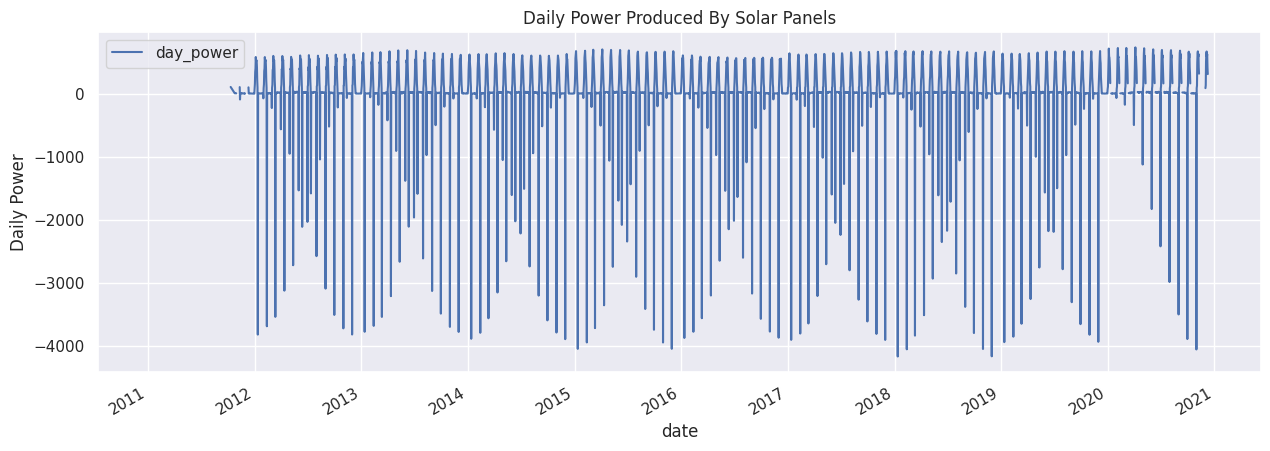

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.set()
power_index= power_info.reset_index()
power_index.plot(kind='line', x='date', y='day_power', figsize=(15,5))

plt.title('Daily Power Produced By Solar Panels')
plt.ylabel('Daily Power')
plt.show()

In [ ]:
def clear_wind(obj):
    if isinstance(obj, str):
        if obj == 'No wind':
            obj = 0
        else:
            obj = obj.replace(' km/h', '')
    return obj
def trans_from_objects(weather):
    weather.drop(['Unnamed: 0'], axis =1, inplace=True)

    #try statement is here for the future weather,
    #as it is without barometer on the site
    try:
        weather.barometer = weather.barometer.apply(lambda x: x.replace(' mbar', '')
                                    if isinstance(x, str) else x).astype(float)
        weather.drop(['visibility'], axis =1, inplace=True)
    except AttributeError:
        pass

    weather.humidity = weather.humidity.apply(lambda x: x.replace('%', '')
                                    if isinstance(x, str) else x).astype(float)
    weather.temp = weather.temp.apply(lambda x: x.replace('°C', '')
                                    if isinstance(x, str) else x).astype(float)
    weather.wind = weather.wind.apply(clear_wind).astype(float)

    return weather

#transfer dataframe from objects dtype to numbers
weather_tran = trans_from_objects(weather)
weather_tran.head()

,clock,temp,weather,wind,humidity,barometer,year,month,day
0,00:20,11.0,Mostly cloudy.,17.0,94.0,1011.0,2012,1,1
1,00:50,12.0,Mostly cloudy.,17.0,88.0,1011.0,2012,1,1
2,01:50,12.0,Overcast.,19.0,88.0,1011.0,2012,1,1
3,02:20,12.0,Partly cloudy.,17.0,88.0,1010.0,2012,1,1
4,02:50,12.0,Sprinkles. Mostly cloudy.,15.0,88.0,1010.0,2012,1,1


In [ ]:
weather_tran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133669 entries, 0 to 133668
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   clock      133669 non-null  object 
 1   temp       133650 non-null  float64
 2   weather    133666 non-null  object 
 3   wind       133623 non-null  float64
 4   humidity   133321 non-null  float64
 5   barometer  133655 non-null  float64
 6   year       133669 non-null  int64  
 7   month      133669 non-null  int64  
 8   day        133669 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 9.2+ MB


In [ ]:
#Form the date column
def create_date(weather):
    weather['date'] = weather.apply(lambda row:
                                    f'{row.year}-{row.month}-{row.day} {row.clock}', axis=1)
    weather.date = pd.to_datetime(weather.date)
    return weather.drop(['clock', 'year', 'month', 'day'], axis = 1)

weather_pretty = create_date(weather_tran)
weather_pretty.head()

,temp,weather,wind,humidity,barometer,date
0,11.0,Mostly cloudy.,17.0,94.0,1011.0,2012-01-01 00:20:00
1,12.0,Mostly cloudy.,17.0,88.0,1011.0,2012-01-01 00:50:00
2,12.0,Overcast.,19.0,88.0,1011.0,2012-01-01 01:50:00
3,12.0,Partly cloudy.,17.0,88.0,1010.0,2012-01-01 02:20:00
4,12.0,Sprinkles. Mostly cloudy.,15.0,88.0,1010.0,2012-01-01 02:50:00


In [ ]:
#to take the average of each day, so we have daily weather. Because we have the daily cum_power not hourly
def take_average_weather(weather, future = False):
    if future == False:
        average_weather = pd.DataFrame(columns = ['temp', 'weather', 'wind', 'humidity', 'barometer',
                                              'date'])
    else:
        average_weather = pd.DataFrame(columns = ['temp', 'weather', 'wind', 'humidity','date'])

    temp, wind, humidity, barometer, counter= [0]*5
    for i in range(len(weather)):
        if future == False:
            if (weather.loc[i, 'date'].time() ==datetime.time(0, 20)) and (i!=0):
                average_weather = average_weather.append({
                    'temp':temp/counter,
                    'wind':wind/counter,
                    'humidity':humidity/counter,
                    'barometer':barometer/counter,
                    'date':pd.to_datetime(weather.loc[i-1, 'date'].date()),
                    'weather':weath
                }, ignore_index=True)
                temp, wind, humidity, barometer, counter= [0]*5

            #Here we'll take the weather status in the most powerful hour (15:20), because you can't take averge
                                                                                                        #here.
            if (weather.loc[i, 'date'].time()==datetime.time(15,20)):
                weath = weather.loc[i, 'weather']
        else:
            # or i==len(weather)-1 , so the last day in the data been appended
            if ((weather.loc[i, 'date'].time() ==datetime.time(0, 0)) and (i!=0)) or (i==len(weather)-1):
                average_weather = average_weather.append({
                    'temp':temp/counter,
                    'wind':wind/counter,
                    'humidity':humidity/counter,
                    'date':pd.to_datetime(weather.loc[i-1, 'date'].date()),
                    'weather':weath
                }, ignore_index=True)
                temp, wind, humidity, barometer, counter= [0]*5

            #Here we'll take the weather status in the most powerful hour (15:20),
            #because you can't take averge with categories.
            if (weather.loc[i, 'date'].time()==datetime.time(15,0)):
                weath = weather.loc[i, 'weather']
        counter += 1
        temp += weather.loc[i, 'temp']
        wind += weather.loc[i, 'wind']
        humidity += weather.loc[i, 'humidity']
        if future == False:
            barometer += weather.loc[i, 'barometer']

    return average_weather
average_weather = take_average_weather(weather_pretty)

Streaming output truncated to the last 5000 lines.
<ipython-input-12-f09cffaa6b44>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
<ipython-input-12-f09cffaa6b44>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
<ipython-input-12-f09cffaa6b44>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
<ipython-input-12-f09cffaa6b44>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
<ipython-input-12-f09cffaa6b44>:13: FutureWarning: The frame.append method is deprecated and 

In [ ]:
def merge_weatherANDpower():
    dataset = average_weather.merge(power_info, on=['date'])
    return dataset.set_index('date')
final_dataset = merge_weatherANDpower()
final_dataset.head()

,temp,weather,wind,humidity,barometer,day_power
date,,,,,,
2012-01-01,12.333333,Overcast.,21.333333,89.333333,1007.866667,80.7
2012-01-02,7.787234,Scattered clouds.,17.212766,81.425532,1009.170213,153.8
2012-01-03,8.208333,Light rain. Fog.,32.354167,78.229167,1007.916667,343.0
2012-01-04,7.354167,Broken clouds.,26.375000,71.041667,1012.687500,397.8
2012-01-05,8.292683,Rain showers. Broken clouds.,39.170732,77.804878,998.219512,580.5


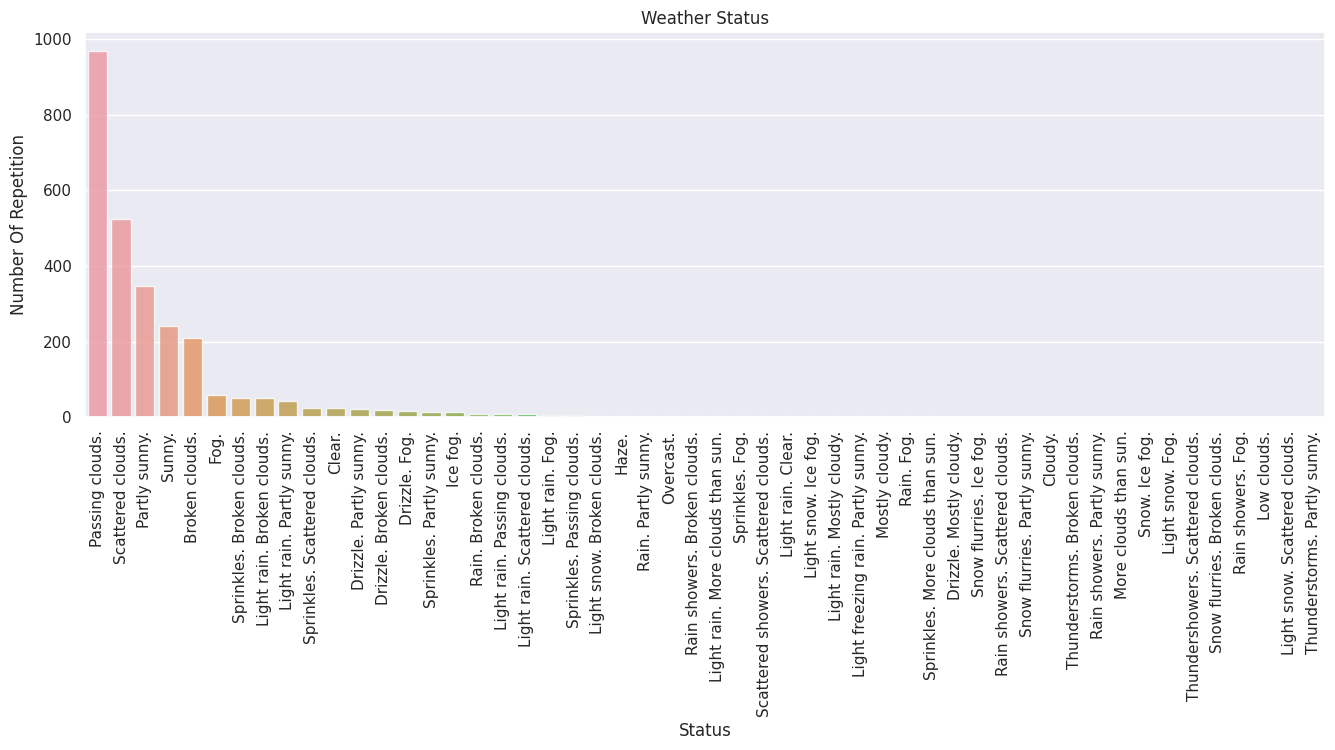

In [ ]:
import seaborn as sns
weather_counts = final_dataset.weather.value_counts()
plt.figure(figsize=(16,5))
sns.barplot(x = weather_counts.index, y = weather_counts.values, alpha=0.8)
plt.xticks(rotation=90)
plt.title('Weather Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show() # WHAT THE HECK! Let's reduce this amount of redundant information

In [ ]:
#I need this, so I can deal with "loc"
final_dataset = final_dataset.reset_index()

def reduce_categories(weather):
    #Delete all first parts of two-part status, and highligh only the necessary categories.
    #why the first part? Because we don't care about the raining or snowing weather, we care more about
    #status of clouds
    for i in range(len(weather)):
        weather_list = weather.loc[i, 'weather'].split('.')
        if len(weather_list) > 2:
            weather.loc[i,'weather'] = weather_list[1].strip()
        elif len(weather_list) ==2:
            weather.loc[i, 'weather'] = weather_list[0].strip()

    weather.weather = weather.weather.map({
        'Ice fog':'Fog',
        'Haze':'Fog',
        'Fog':'Fog',
        'Clear':'Sunny',
        'Sunny':'Sunny',
        'Broken clouds':'Scattered clouds',
        'Scattered clouds':'Scattered clouds',
        'Overcast':'Cloudy',
        'More clouds than sun':'Cloudy',
        'More sun than clouds':'Sunny',
        'Low clouds':'Cloudy',
        'Mostly cloudy':'Cloudy',
        'Cloudy':'Cloudy',
        'Passing clouds':'Passing clouds',
        'Partly sunny':'Partly sunny',
        'Mostly sunny':'Sunny'
    },na_action='ignore')
    return weather
final_dataset = reduce_categories(final_dataset)

#get the index back to "date"
final_dataset.set_index('date', inplace=True)

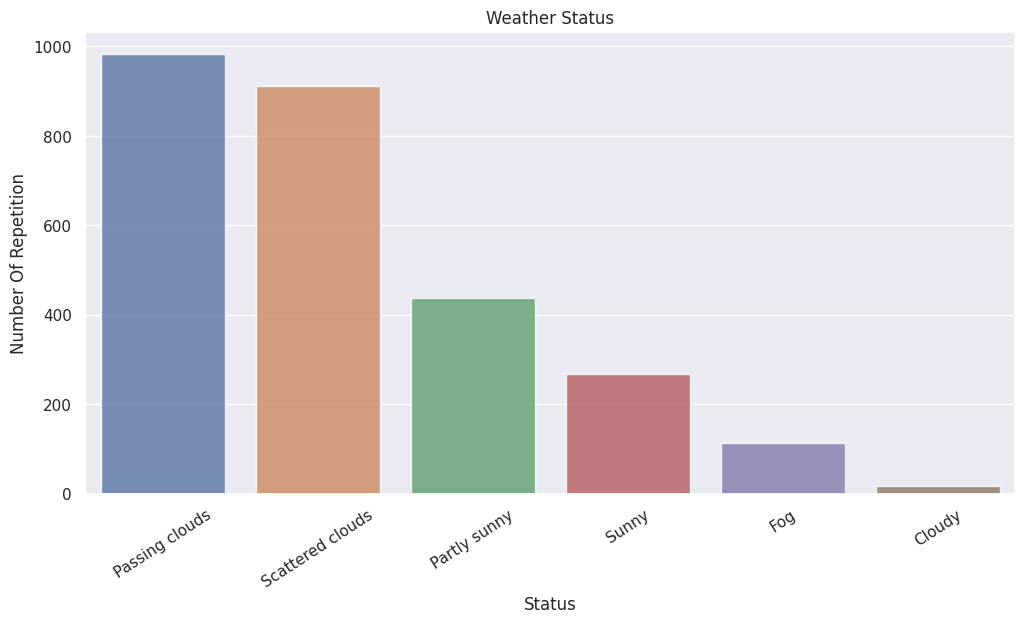

In [ ]:
from matplotlib import pyplot as plt
final_dataset.weather.value_counts()
weather_counts = final_dataset.weather.value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x = weather_counts.index, y = weather_counts.values, alpha=0.8)
plt.xticks(rotation=33)
plt.title('Weather Status')
plt.xlabel('Status')
plt.ylabel('Number Of Repetition')
plt.show()

In [ ]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2731 entries, 2012-01-01 to 2019-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   temp       2726 non-null   float64
 1   weather    2731 non-null   object 
 2   wind       2718 non-null   float64
 3   humidity   2708 non-null   float64
 4   barometer  2726 non-null   float64
 5   day_power  2731 non-null   float64
dtypes: float64(5), object(1)
memory usage: 149.4+ KB


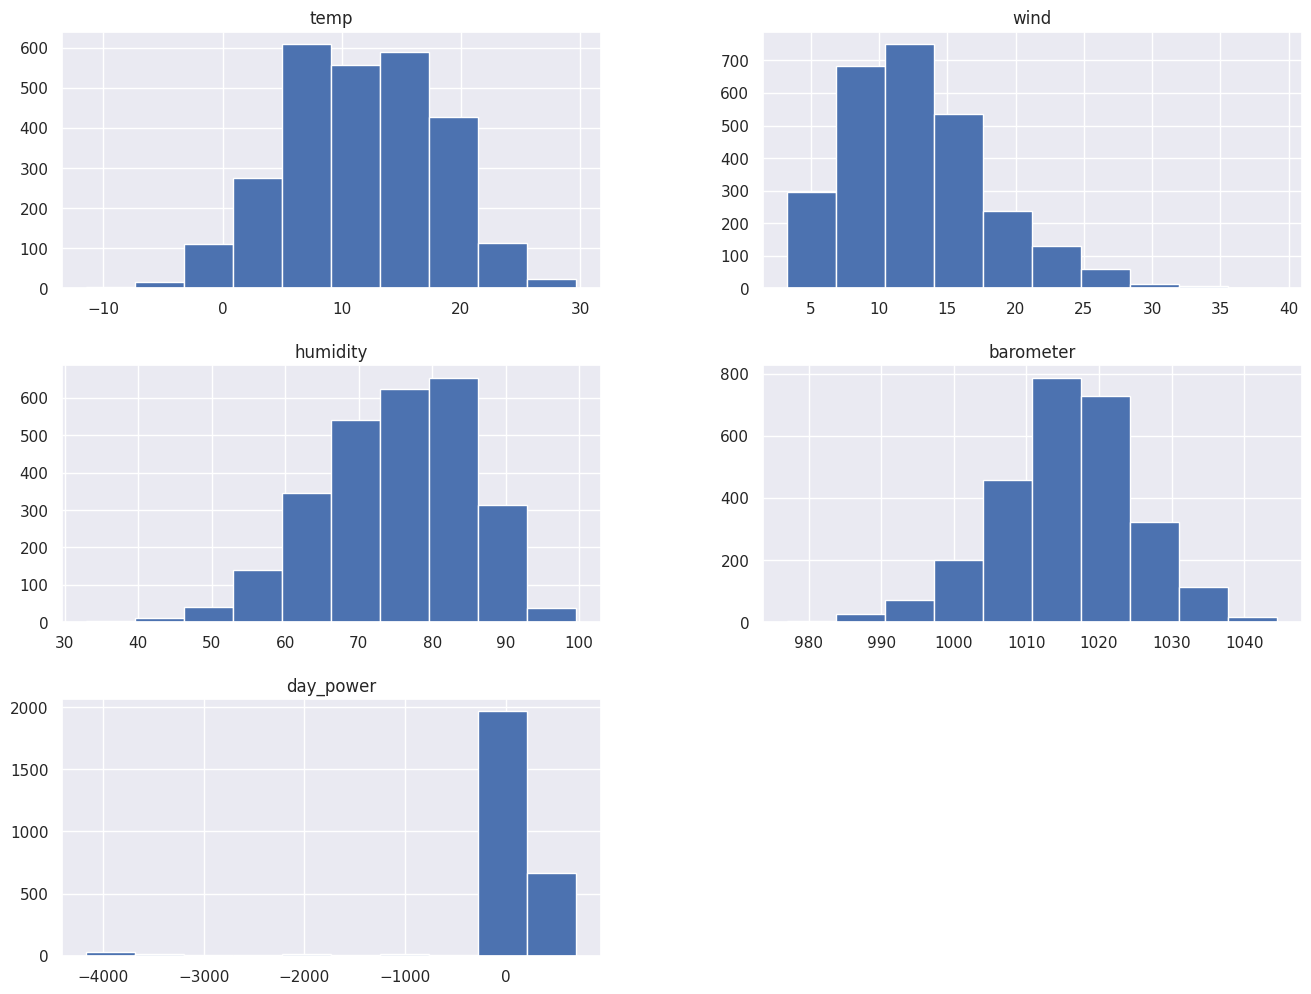

In [ ]:
final_dataset.hist(figsize=(16,12))
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(final_dataset, test_size=0.2,
                                                   random_state=42)
df = train_set.copy()
df.describe()

,temp,wind,humidity,barometer,day_power
count,2180.000000,2173.000000,2165.000000,2180.000000,2184.000000
mean,11.474390,12.921205,75.403274,1015.556859,44.857601
std,6.343690,5.356622,10.004430,9.482471,601.289346
min,-11.437500,3.250000,32.914894,977.041667,-4168.000000
25%,6.706782,9.000000,68.239130,1009.952460,5.000000
50%,11.375000,12.063830,76.416667,1015.850000,19.000000
75%,16.470855,16.063830,83.108696,1021.752717,204.250000
max,29.680851,39.170732,98.000000,1044.541667,701.000000


In [ ]:
df.corr()

<ipython-input-20-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,temp,wind,humidity,barometer,day_power
temp,1.000000,-0.113156,-0.454889,-0.035408,0.055466
wind,-0.113156,1.000000,0.017362,-0.379477,-0.005130
humidity,-0.454889,0.017362,1.000000,-0.155610,-0.018554
barometer,-0.035408,-0.379477,-0.155610,1.000000,-0.015741
day_power,0.055466,-0.005130,-0.018554,-0.015741,1.000000


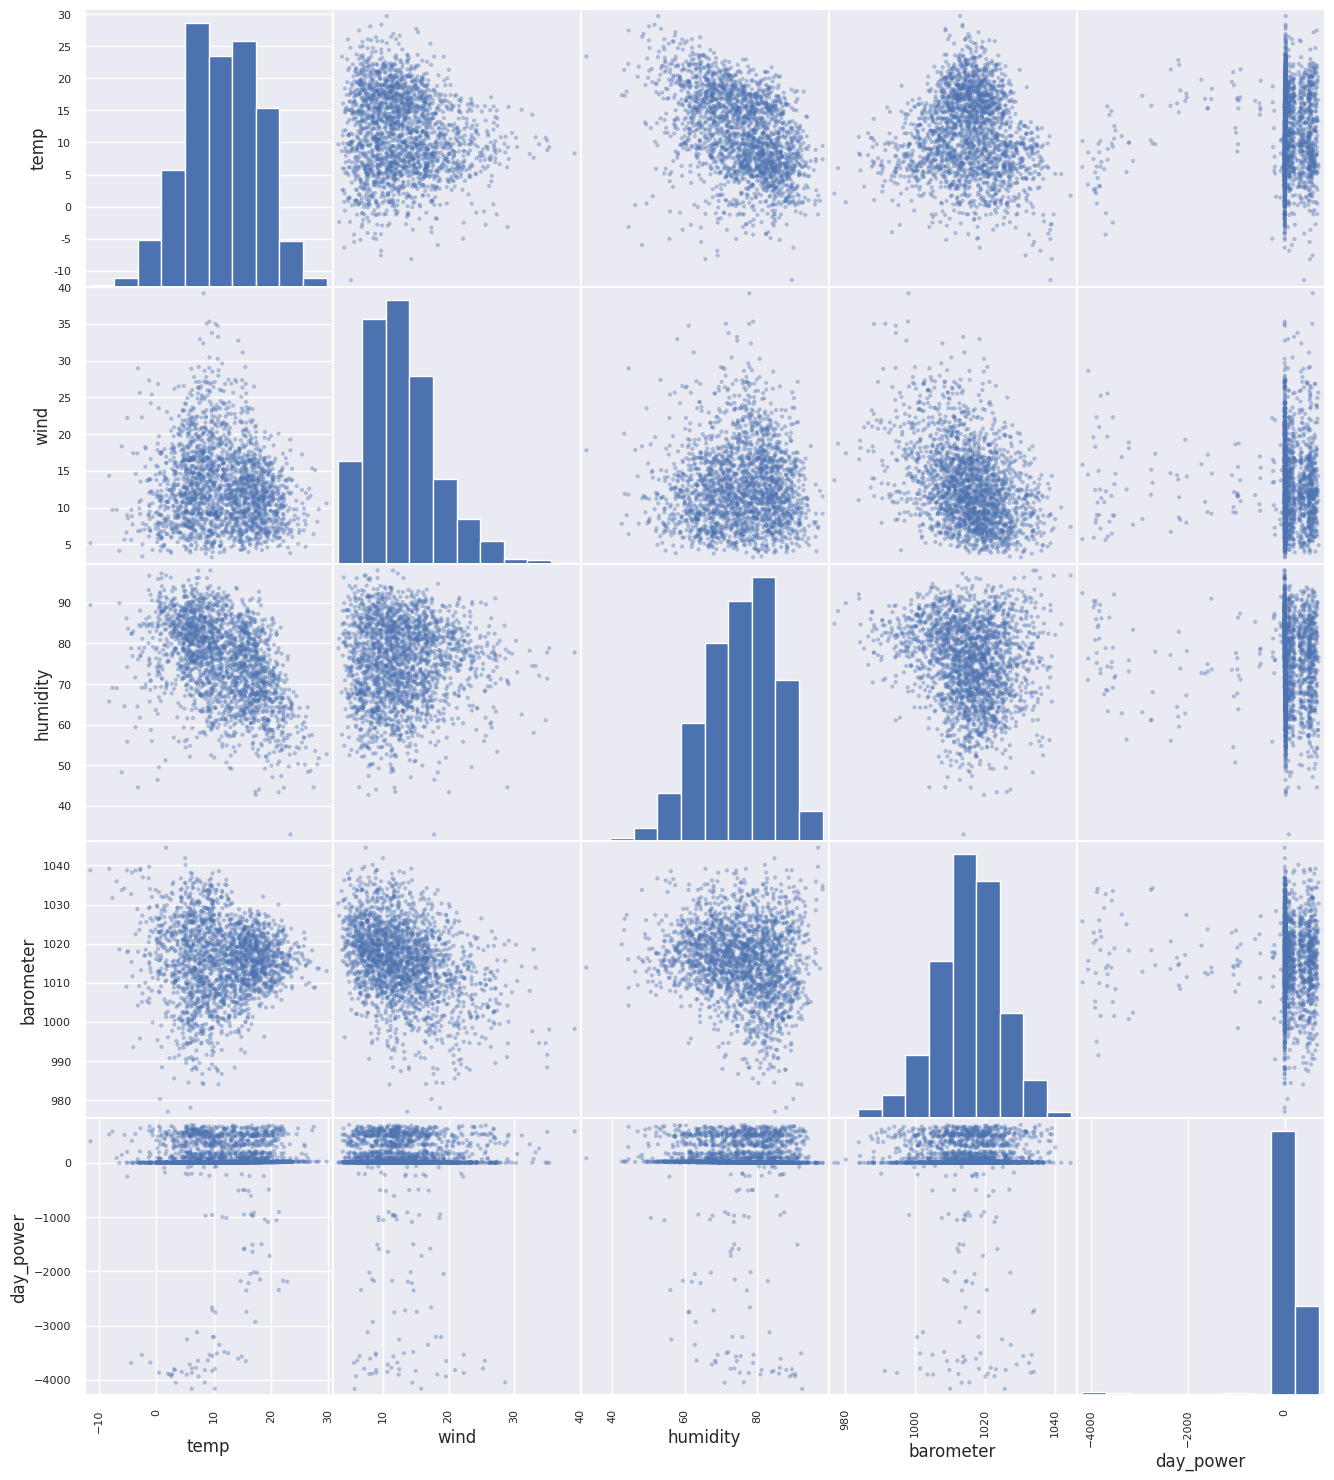

In [ ]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, figsize=(16,18), alpha=0.4)
plt.show()

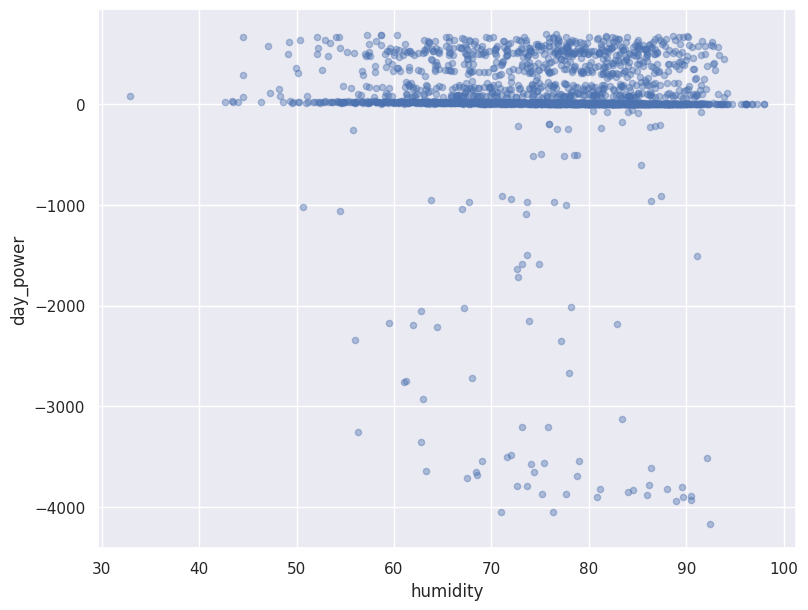

In [ ]:
df.plot(kind='scatter', x= 'humidity',y='day_power', figsize=(9,7), alpha=0.4)
plt.show()

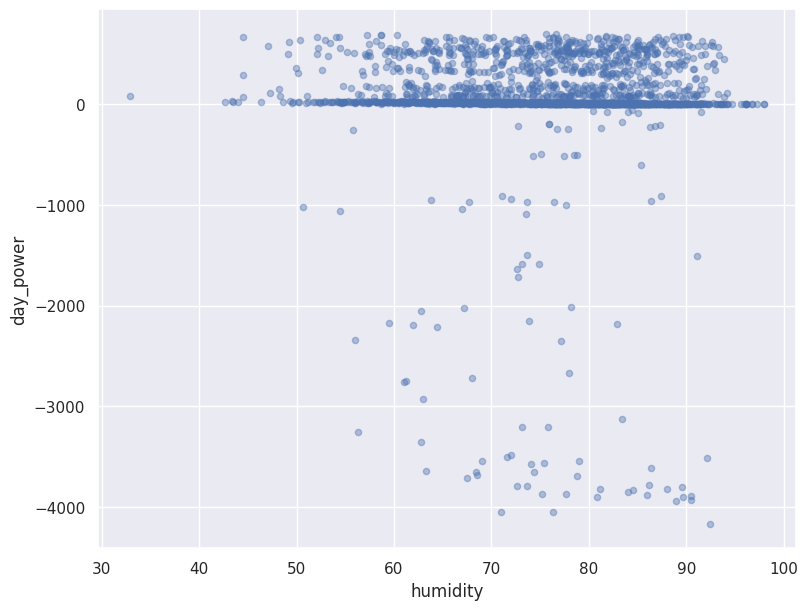

In [ ]:
#To delete data anomalies
import random
df.day_power = df.day_power.apply(lambda x: x+random.randint(0,50)/100 if x==0 else x)
for i in range(1,34):
    df.day_power = df.day_power.apply(lambda x: x+random.randint(-50,50)/100 if x==i else x)
df.plot(kind='scatter', x= 'humidity',y='day_power', figsize=(9,7), alpha=0.4)
plt.show()

In [ ]:
#As we have data (which we want to predict), without barometer column
features = df.drop(['day_power', 'barometer'], axis=1)
columns=features.columns
labels = df['day_power'].copy()
features.head()

,temp,weather,wind,humidity
date,,,,
2013-01-01,7.166667,Scattered clouds,19.312500,83.854167
2017-05-22,18.291667,Passing clouds,7.145833,55.270833
2015-03-15,5.595745,Scattered clouds,14.021277,80.468085
2018-02-18,0.377778,Passing clouds,6.377778,84.355556
2015-02-03,1.723404,Passing clouds,8.404255,83.553191


In [ ]:
num_attr = list(features.drop(['weather'],axis=1))
cat_attr = ['weather']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler


num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

cat_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

full_pipeline = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_attr),
    ('cat_pipeline', cat_pipeline, cat_attr)
])

In [ ]:
prepared_features = full_pipeline.fit_transform(features)

In [ ]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score

lin_reg = LinearRegression()
lin_reg.fit(prepared_features, labels)
y_predicted = lin_reg.predict(prepared_features)
scores = cross_val_score(lin_reg, prepared_features, labels,
                         scoring='neg_mean_squared_error', cv=10)
scores=np.sqrt(-scores)
display(scores.mean())
scores.std()

586.0138780900545

138.5645160301359

In [ ]:
test = test_set.copy()
test_features = test.drop(['day_power', 'barometer'], axis=1)
test_labels = test['day_power'].copy()

In [ ]:
prepared_test = full_pipeline.transform(test_features)
test_predicted = lin_reg.predict(prepared_test)

In [ ]:
scores = cross_val_score(lin_reg, prepared_test, test_labels,
                         scoring='neg_mean_squared_error', cv=10)
scores=np.sqrt(-scores)
display(scores.mean())
scores.std()

564.7933369423496

192.5914996949793

In [ ]:
import joblib

# Assuming 'lin_reg' is your trained LinearRegression model
joblib.dump(lin_reg, 'linear_regression_model.h5')

['linear_regression_model.h5']

In [ ]:
#Visualizing the difference between predicted and real values of day power for the test set

avg=[]
labels_avg = []
for i in range(len(test_labels)):
    avg.append(test_labels[i])
    if i % 40 == 0:
        labels_avg.append(np.array(avg).mean())
        avg.clear()
avg=[]
pred_avg = []
for i in range(len(test_predicted)):
    avg.append(test_predicted[i])
    if i % 40 == 0:
        pred_avg.append(np.array(avg).mean())
        avg.clear()

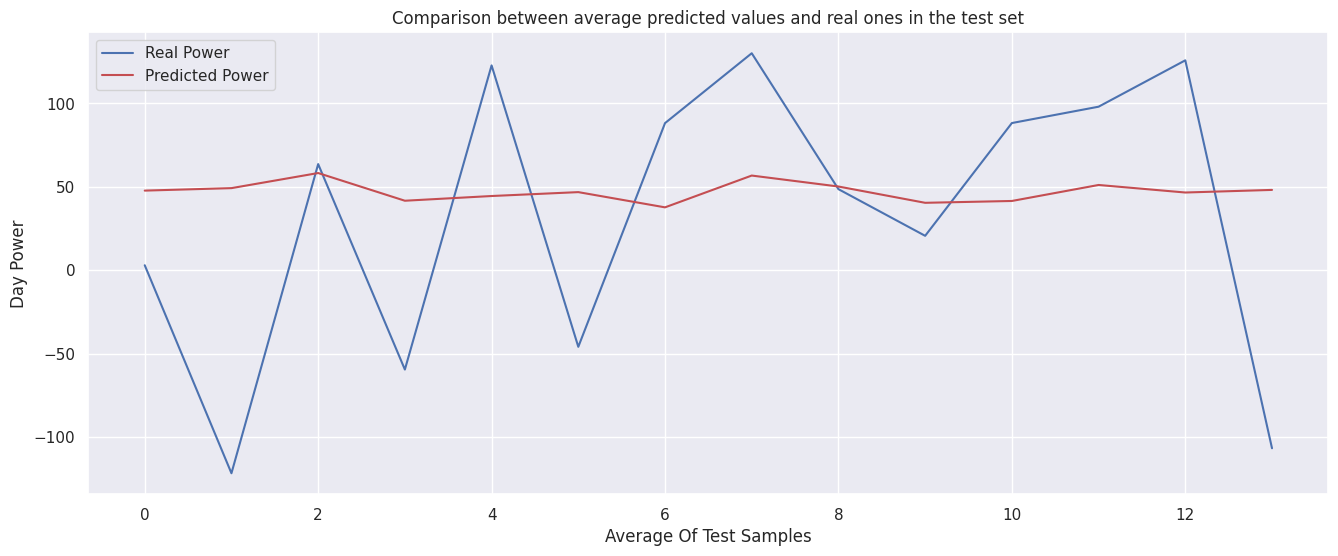

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(range(len(labels_avg)), labels_avg)
plt.plot(range(len(pred_avg)), pred_avg, 'r')
plt.title('Comparison between average predicted values and real ones in the test set')
plt.ylabel('Day Power')
plt.xlabel('Average Of Test Samples')
plt.legend(['Real Power', 'Predicted Power'])
plt.show()

In [ ]:
weather_future= pd.read_csv('/content/gdrive/MyDrive/Prediction/weather_in_Antwerp_future2.csv', ';')

<ipython-input-35-212896275ad8>:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  weather_future= pd.read_csv('/content/gdrive/MyDrive/Prediction/weather_in_Antwerp_future2.csv', ';')


In [ ]:
def predict_future_data(data):
    tran_fut = trans_from_objects(data)
    tran_fut = create_date(tran_fut)
    avg_fut = take_average_weather(tran_fut, future=True)
    red_fut = reduce_categories(avg_fut)
    red_fut = red_fut.set_index('date')
    prepared_future = full_pipeline.transform(red_fut)
    return red_fut.index, lin_reg.predict(prepared_future)

date, predicted_data = predict_future_data(weather_future)

<ipython-input-12-f09cffaa6b44>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
<ipython-input-12-f09cffaa6b44>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
<ipython-input-12-f09cffaa6b44>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
<ipython-input-12-f09cffaa6b44>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  average_weather = average_weather.append({
<ipython-input-12-f09cffaa6b44>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

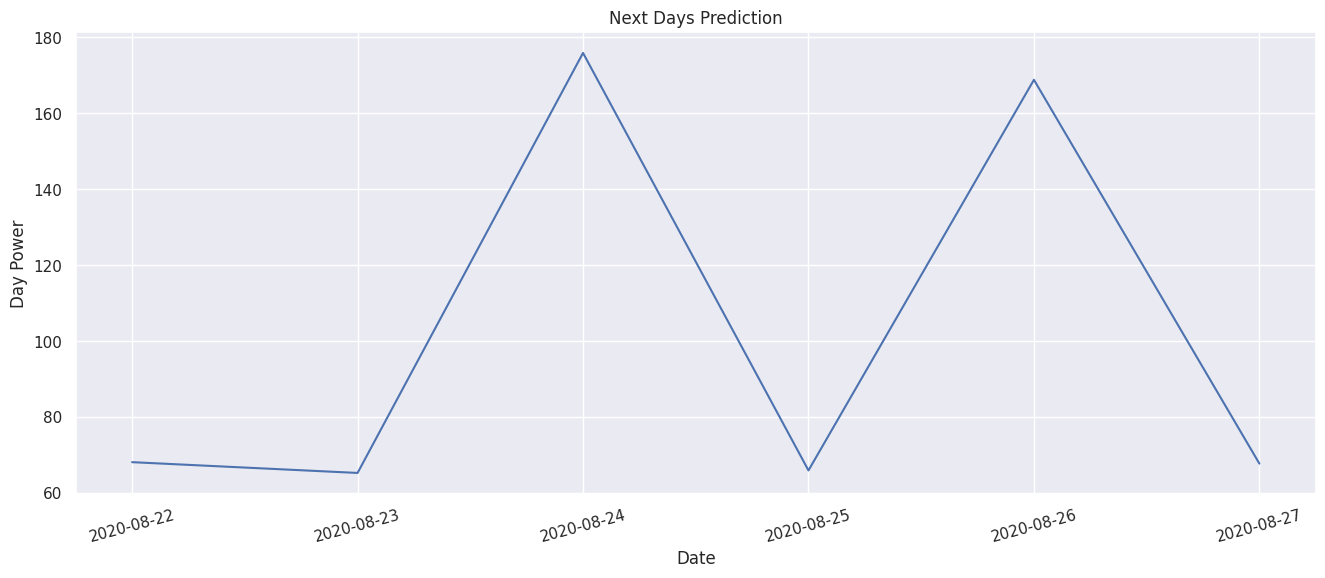

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(date,predicted_data)
plt.title('Next Days Prediction')
plt.ylabel('Day Power')
plt.xlabel('Date')
plt.rcParams['xtick.labelsize']=14
plt.rcParams['ytick.labelsize']=14
plt.xticks(rotation=15)
plt.show()

In [ ]:
import joblib
model_filename = 'prediction.pkl'
joblib.dump(lin_reg, model_filename)
print(f'Model saved as {model_filename}')

Model saved as prediction.pkl


In [ ]:
loaded_model = joblib.load('prediction.pkl')
coefficients = loaded_model.coef_
intercept = loaded_model.intercept_
with open('prediction.h', 'w') as f:
    f.write('#ifndef LINEAR_REGRESSION_MODEL_H\n')
    f.write('#define LINEAR_REGRESSION_MODEL_H\n\n')

    f.write('const float coefficients[] = {\n')
    f.write(', '.join([f'{coef:.8f}' for coef in coefficients]))
    f.write('\n};\n')

    f.write(f'const float intercept = {intercept:.8f};\n\n')

    f.write('#endif // LINEAR_REGRESSION_MODEL_H\n')


In [ ]:
import pickle

with open('prediction.pkl', 'wb') as pkl_file:
    pickle.dump(loaded_model, pkl_file, protocol=4)

In [ ]:
import joblib

# Load the saved model
with open('prediction.pkl', 'rb') as pkl_file:
    model = joblib.load(pkl_file)